# Purpose
This notebook is used to map note_number, velocity, instrument_source, qualities, z to f0_scaled and ld_scaled. The model is created using WaveNet architecture

# Setup google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
!pip install -qU ddsp[data_preparation]==1.0.1
!pip install keras-tcn

     |████████████████████████████████| 174kB 10.9MB/s 
     |████████████████████████████████| 3.6MB 15.4MB/s 
     |████████████████████████████████| 3.9MB 35.9MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
     |████████████████████████████████| 215kB 39.8MB/s 
     |████████████████████████████████| 9.6MB 38.0MB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 5.6MB 40.7MB/s 
     |████████████████████████████████| 378kB 43.8MB/s 
     |████████████████████████████████| 2.3MB 31.1MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement dill<0.3.2,>=0.3.1.1, but you'll have dill 0.3.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement future<1.0.0,>=0.18.2, but you'll have future 0.16.0 which is incompatible.
ERROR: apache-beam

# Make directories to save model and data

In [3]:
import os
import datetime
from tcn import TCN, tcn_full_summary

drive_dir = '/content/drive/My Drive/Sound_generation'
checkpoint_dir = os.path.join(drive_dir, 'mapping/WaveNet_checkpoint')

assert os.path.exists(drive_dir)
print('Drive Directory Exists:', drive_dir)

!mkdir -p "$checkpoint_dir"


Drive Directory Exists: /content/drive/My Drive/Sound_generation


# Download Complete NSynth Guitar Subse

In [4]:
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

dataset_dir = '/content/complete_dataset'
if not os.path.exists(dataset_dir):
  folder_name = folder_download('1-lJfBAVswi8JXR_kKbOkfvNHRNvAZ1TB')

train_dataset_dir = os.path.join(dataset_dir, 'train')
valid_dataset_dir = os.path.join(dataset_dir, 'valid')
test_dataset_dir = os.path.join(dataset_dir, 'test')

train_tfrecord_file = os.path.join(train_dataset_dir, 'complete.tfrecord')
valid_tfrecord_file = os.path.join(valid_dataset_dir, 'complete.tfrecord')
test_tfrecord_file = os.path.join(test_dataset_dir, 'complete.tfrecord')

1FsZQDIrOJk45xMseqAN2AFyNfqn5HLJQ test application/vnd.google-apps.folder (1/3)
1-1VdcAiI48LdnvPxgoaVJukosX9ffBAy complete.tfrecord application/octet-stream (1/1)
Download 100%.
1v4WA3pRGIQtuF0Fxs_eFLsPlLusw5nC8 train application/vnd.google-apps.folder (2/3)
1-1WPFZ-3Kys0A4OxRPUPquk1b2mY7pKm complete.tfrecord application/octet-stream (1/1)
Download 100%.
14pWJXJDISbHJY90Wm8oROSZeErOODCiw valid application/vnd.google-apps.folder (3/3)
126Zj9AsvFXeBAtma73FBae738xMSRo5R complete.tfrecord application/octet-stream (1/1)
Download 100%.


# Copying data to drive or from drive

In [ ]:
# !cp -r  /content/drive/MyDrive/Sound_generation/mapping/complete  ./

# Defining Data class provider


In [5]:
import tensorflow as tf
import ddsp.training.data as data

class CompleteTFRecordProvider(data.RecordProvider):
  def __init__(self,
               file_pattern=None,
               example_secs=4,
               sample_rate=16000,
               frame_rate=250,
               map_func=None):
    super().__init__(file_pattern, example_secs, sample_rate,
                      frame_rate, tf.data.TFRecordDataset)
    self._map_func = map_func

  def get_dataset(self, shuffle=True):
    def parse_tfexample(record):
      features = tf.io.parse_single_example(record, self.features_dict)
      if self._map_func is not None:
        return self._map_func(features)
      else:
        return features

    filenames = tf.data.Dataset.list_files(self._file_pattern, shuffle=shuffle)
    dataset = filenames.interleave(
        map_func=self._data_format_map_fn,
        cycle_length=40,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_tfexample,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

  @property
  def features_dict(self):
    return {
      'sample_name':
        tf.io.FixedLenFeature([1], dtype=tf.string),
      'note_number':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'velocity':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'instrument_source':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'qualities':
        tf.io.FixedLenFeature([10], dtype=tf.int64),
      'audio':
        tf.io.FixedLenFeature([self._audio_length], dtype=tf.float32),
      'f0_hz':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'f0_confidence':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'loudness_db':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'f0_scaled':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'ld_scaled':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'z':
        tf.io.FixedLenFeature([self._feature_length * 16], dtype=tf.float32),
    }


# Defining feature mapping function


In [24]:

def features_map(features):
  note_number = features['note_number']
  velocity = features['velocity']
  instrument_source = features['instrument_source']
  qualities = features['qualities']
  f0_scaled = features['f0_scaled']
  ld_scaled = features['ld_scaled']
  z = features['z']

  sequence_length = f0_scaled.shape[0]

  def convert_to_sequence(feature):
    channels = feature.shape[0]
    feature = tf.expand_dims(feature, axis=0)

    feature = tf.broadcast_to(feature, shape=(sequence_length, channels))
    feature = tf.cast(feature, dtype=tf.float32)
    
    return feature

  # Normalize data
  # 0-127
  note_number = note_number / 127
  velocity = velocity / 127

  # 0-2
  # 0	acoustic, 1	electronic, 2	synthetic
  instrument_source = instrument_source / 2

  # Prepare dataset for a sequence to sequence mapping
  note_number = convert_to_sequence(note_number)
  velocity = convert_to_sequence(velocity)
  instrument_source = convert_to_sequence(instrument_source)
  qualities = convert_to_sequence(qualities)

  f0_scaled = tf.expand_dims(f0_scaled, axis=-1)
  f0_variation = f0_scaled * 127.0 - tf.cast(note_number, dtype=tf.float32)
  f0_variation = tf.clip_by_value(f0_variation, -1.0, 1.0)
  f0_variation = tf.expand_dims(f0_variation, axis=-1)

  ld_scaled = tf.expand_dims(ld_scaled, axis=-1)
  z = tf.reshape(z, shape=(sequence_length, 16))

  inputs = tf.concat(
      [note_number, velocity, instrument_source, qualities, z],
      axis=-1)
  
  targets = tf.concat(
      [f0_scaled, ld_scaled],
      axis=-1)

  final_inputs = {
        'inputs': inputs,
        'targets': tf.pad(targets[0:-1, :], [[1, 0], [0, 0]])
  }

  return final_inputs, targets

# Create Datasets

In [25]:
batch_size = 16
example_secs = 4
sample_rate = 16000
frame_rate = 250

# Create train dataset
train_data_provider = CompleteTFRecordProvider(
    file_pattern=train_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

train_dataset = train_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create valid dataset
valid_data_provider = CompleteTFRecordProvider(
    file_pattern=valid_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

valid_dataset = valid_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create test dataset
test_data_provider = CompleteTFRecordProvider(
    file_pattern=test_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

test_dataset = test_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

In [26]:
for i in train_dataset.take(1):
  x = i[0]
  y = i[1]
  print(x)
  print(y)

{'inputs': <tf.Tensor: shape=(16, 1000, 29), dtype=float32, numpy=
array([[[ 0.6456693 ,  0.39370078,  0.        , ..., -1.4880818 ,
          0.30027932,  2.4306426 ],
        [ 0.6456693 ,  0.39370078,  0.        , ..., -1.3877788 ,
          0.5606576 ,  2.6928258 ],
        [ 0.6456693 ,  0.39370078,  0.        , ..., -1.2874758 ,
          0.82103586,  2.955009  ],
        ...,
        [ 0.6456693 ,  0.39370078,  0.        , ..., -2.3602288 ,
         -1.693045  , -1.6447955 ],
        [ 0.6456693 ,  0.39370078,  0.        , ..., -2.3602288 ,
         -1.693045  , -1.6447955 ],
        [ 0.6456693 ,  0.39370078,  0.        , ..., -2.3602288 ,
         -1.693045  , -1.6447955 ]],

       [[ 0.20472442,  0.19685039,  0.5       , ..., -1.6495433 ,
          0.66103804,  0.15080546],
        [ 0.20472442,  0.19685039,  0.5       , ..., -1.5882995 ,
          0.7044592 ,  0.19951206],
        [ 0.20472442,  0.19685039,  0.5       , ..., -1.5270557 ,
          0.74788034,  0.24821866],


# Create and compile mapping model
 - WaveNet Implementation 


In [9]:
class ReLU(tf.keras.layers.ReLU):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def call(self, inputs, is_synthesis=False):
        return super().call(inputs)



class Conv1D(tf.keras.layers.Conv1D):
    def __init__(self, filters, kernel_size, strides=1, padding='causal',
                 dilation_rate=1, residual_channels=None, *args, **kwargs):
        super().__init__(filters, kernel_size, strides=strides, padding=padding,
                         dilation_rate=dilation_rate)

        self.k = kernel_size
        self.d = dilation_rate

        if kernel_size > 1:
            self.queue_len = kernel_size + (kernel_size - 1) * (dilation_rate - 1)
            self.queue_dim = residual_channels
            self.init_queue()

    def build(self, input_shape):
        super().build(input_shape)

        self.linearized_weights = tf.cast(tf.reshape(self.kernel, [-1, self.filters]), dtype=tf.float32)

    def call(self, inputs, is_synthesis=False):
        if not is_synthesis:
            return super().call(inputs)

        if self.k > 1:
            self.queue = self.queue[:, 1:, :]
            self.queue = tf.concat([self.queue, tf.expand_dims(inputs[:, -1, :], axis=1)], axis=1)

            if self.d > 1:
                inputs = self.queue[:, 0::self.d, :]
            else:
                inputs = self.queue

        outputs = tf.matmul(tf.reshape(inputs, [1, -1]), self.linearized_weights)
        outputs = tf.nn.bias_add(outputs, self.bias)

        # [batch_size, 1(time_len), channels]
        return tf.reshape(outputs, [-1, 1, self.filters])

    def init_queue(self):
        self.queue = tf.zeros([1, self.queue_len, self.queue_dim], dtype=tf.float32)


class ResidualConv1DGLU(tf.keras.Model):
    """
        conv1d + GLU => add condition => residual add + skip connection
    """

    def __init__(self, residual_channels, gate_channels, kernel_size,
                 skip_out_channels=None, dilation_rate=1, **kwargs):
        super().__init__()

        self.residual_channels = residual_channels

        if skip_out_channels is None:
            skip_out_channels = residual_channels

        self.dilated_conv = Conv1D(gate_channels,
                                   kernel_size=kernel_size,
                                   padding='causal',
                                   dilation_rate=dilation_rate,
                                   residual_channels=residual_channels)

        self.conv_c = Conv1D(gate_channels,
                             kernel_size=1,
                             padding='causal')

        self.conv_skip = Conv1D(skip_out_channels,
                                kernel_size=1,
                                padding='causal')
        self.conv_out = Conv1D(residual_channels,
                               kernel_size=1,
                               padding='causal')

    @tf.function
    def call(self, inputs, c):
        x = self.dilated_conv(inputs)
        x_tanh, x_sigmoid = tf.split(x, num_or_size_splits=2, axis=2)

        c = self.conv_c(c)
        c_tanh, c_sigmoid = tf.split(c, num_or_size_splits=2, axis=2)

        x_tanh, x_sigmoid = x_tanh + c_tanh, x_sigmoid + c_sigmoid
        x = tf.nn.tanh(x_tanh) * tf.nn.sigmoid(x_sigmoid)

        s = self.conv_skip(x)
        x = self.conv_out(x)

        x = x + inputs

        return x, s

    def init_queue(self):
        self.dilated_conv.init_queue()

    def synthesis_feed(self, inputs, c):
        x = self.dilated_conv(inputs, is_synthesis=True)
        x_tanh, x_sigmoid = tf.split(x, num_or_size_splits=2, axis=2)

        c = self.conv_c(c, is_synthesis=True)
        c_tanh, c_sigmoid = tf.split(c, num_or_size_splits=2, axis=2)

        x_tanh, x_sigmoid = x_tanh + c_tanh, x_sigmoid + c_sigmoid
        x = tf.nn.tanh(x_tanh) * tf.nn.sigmoid(x_sigmoid)

        s = self.conv_skip(x, is_synthesis=True)
        x = self.conv_out(x, is_synthesis=True)

        x = x + inputs

        return x, s


class CrossEntropyLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes=256, name=None):
        super().__init__()
        self.num_classes = num_classes

    def call(self, targets, outputs):
        targets_ = tf.one_hot(targets, depth=self.num_classes)
        losses = tf.nn.softmax_cross_entropy_with_logits(labels=targets_, logits=outputs)

        return tf.reduce_mean(losses)

In [60]:
class WaveNet(tf.keras.Model):
    def __init__(self):
        super().__init__()

        #self.upsample_network = UpsampleNetwork(upsample_scales)

        self.first_layer = Conv1D(128,
                                  kernel_size=1,
                                  padding='causal')

        self.residual_blocks = []
        for _ in range(2):
            for i in range(10):
                self.residual_blocks.append(
                    ResidualConv1DGLU(128,
                                      256,
                                      kernel_size=3,
                                      skip_out_channels=128,
                                      dilation_rate=2 ** i)
                )

        self.final_layers = [
            ReLU(),
            Conv1D(128,
                   kernel_size=1,
                   padding='causal'),
            ReLU(),
            Conv1D(2,
                   kernel_size=1,
                   padding='causal')
        ]

    @tf.function
    def call(self, inputs):
        c = inputs['inputs']
        temp_input =  inputs['targets']

        # c = tf.expand_dims(c, axis=-1)
        # print(c.shape)
        # #c = self.upsample_network(c)
        # c = tf.transpose(tf.squeeze(c, axis=-1), perm=[0, 2, 1])
        # print(c.shape)

        x = self.first_layer(temp_input)
        skips = None
        for block in self.residual_blocks:
            x, h = block(x, c)
            if skips is None:
                skips = h
            else:
                skips = skips + h

        x = skips
        for layer in self.final_layers:
            x = layer(x)

        return x

    def init_queue(self):
        for block in self.residual_blocks:
            block.init_queue()

    def synthesis(self, c):
        c = tf.expand_dims(c, axis=-1)
        #c = self.upsample_network(c)
        
        c = tf.transpose(tf.squeeze(c, axis=-1), perm=[0, 2, 1])

        batch_size, time_len, _ = c.shape
        #initial_value = mulaw_quantize(0, 256)
        inputs = tf.one_hot(indices=initial_value,
                            depth=256, dtype=tf.float32)
        inputs = tf.tile(tf.reshape(inputs, [1, 1, 256]),
                         [batch_size, 1, 1])

        outputs = []
        for i in range(time_len):
            c_t = tf.expand_dims(c[:, i, :], axis=1)

            x = self.first_layer(inputs, is_synthesis=True)

            skips = None
            for block in self.residual_blocks:
                x, h = block.synthesis_feed(x, c_t)

                if skips is not None:
                    skips = skips + h
                else:
                    skips = h

            x = skips
            for layer in self.final_layers:
                x = layer(x, is_synthesis=True)

            x = tf.argmax(tf.squeeze(x, axis=1), axis=-1)
            x = tf.one_hot(x, depth=2)
            inputs = x

            outputs.append(tf.argmax(x, axis=1).numpy())

        outputs = np.array(outputs)

        return np.transpose(outputs, [1, 0])


### Hyperparameters

# Building the model

In [61]:
model = WaveNet()

In [62]:
x_train, y_train = next(iter(train_dataset))
out = model(x_train)

print(model.summary())

Model: "wave_net_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_581 (Conv1D)          multiple                  384       
_________________________________________________________________
residual_conv1dglu_140 (Resi multiple                  139264    
_________________________________________________________________
residual_conv1dglu_141 (Resi multiple                  139264    
_________________________________________________________________
residual_conv1dglu_142 (Resi multiple                  139264    
_________________________________________________________________
residual_conv1dglu_143 (Resi multiple                  139264    
_________________________________________________________________
residual_conv1dglu_144 (Resi multiple                  139264    
_________________________________________________________________
residual_conv1dglu_145 (Resi multiple                  1

# Load checkpoints

In [63]:
import shutil

try:
    shutil.rmtree(checkpoint_dir)
except OSError as e:
    print("Error: %s : %s" % (checkpoint_dir, e.strerror))

Error: /content/drive/My Drive/Sound_generation/mapping/WaveNet_checkpoint : No such file or directory


In [64]:
checkpoint_file = os.path.join(checkpoint_dir, 'cp.ckpt')

if os.path.isdir(checkpoint_dir) and os.listdir(checkpoint_dir):
    model.load_weights(checkpoint_file)

# Create training callbacks


In [65]:

learning_rate = 1e-3
beta_1 = 0.9
exponential_decay_rate = 0.5
exponential_decay_steps = 200000
epoch = 2000
batch_size = 8


In [66]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=True,
    verbose=0,
    save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * 0.9


lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                                 decay_steps=exponential_decay_steps,
                                                                 decay_rate=exponential_decay_rate)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                         beta_1=beta_1)


loss = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.losses.MeanSquaredError()])
log_dir = "logs/fit/loudness_f0_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model


In [67]:
epochs = 100
steps_per_epoch = 100
validation_steps = 10

with tf.device('/device:GPU:0'):
  model.fit(train_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=[checkpoint])

Epoch 1/100
100/100 [==============================] - 25s 172ms/step - loss: 0.3430 - mean_squared_error: 0.4621 - val_loss: 0.0444 - val_mean_squared_error: 0.0043
Epoch 2/100
100/100 [==============================] - 16s 164ms/step - loss: 0.0473 - mean_squared_error: 0.0046 - val_loss: 0.0285 - val_mean_squared_error: 0.0020
Epoch 3/100
100/100 [==============================] - 17s 165ms/step - loss: 0.0322 - mean_squared_error: 0.0023 - val_loss: 0.0280 - val_mean_squared_error: 0.0015
Epoch 4/100
100/100 [==============================] - 17s 166ms/step - loss: 0.0247 - mean_squared_error: 0.0014 - val_loss: 0.0170 - val_mean_squared_error: 7.1035e-04
Epoch 5/100
100/100 [==============================] - 16s 164ms/step - loss: 0.0227 - mean_squared_error: 0.0011 - val_loss: 0.0181 - val_mean_squared_error: 8.3991e-04
Epoch 6/100
100/100 [==============================] - 16s 164ms/step - loss: 0.0249 - mean_squared_error: 0.0014 - val_loss: 0.0140 - val_mean_squared_error: 5.1

# Evaluate the model

In [68]:
model.evaluate(test_dataset,steps=500)

500/500 [==============================] - 32s 63ms/step - loss: 0.0074 - mean_squared_error: 1.7627e-04


[0.007440061774104834, 0.00017626567569095641]

In [69]:
gin_file_path = '/content/drive/MyDrive/ddsp_generator/operative_config-30000.gin'
ddsp_model_path = '/content/drive/MyDrive/ddsp_generator'

In [70]:
import ddsp.training
from ddsp.training.preprocessing import F0LoudnessPreprocessor
import gin
import matplotlib.pyplot as plt
from IPython.display import Audio

sr = 16000

ddsp_dir = '/content/drive/MyDrive/ddsp_generator'

# Parse the gin config.
gin_file = '/content/drive/MyDrive/ddsp_generator/operative_config-30000.gin'
gin.parse_config_file(gin_file)

# Load model
ddsp_model = ddsp.training.models.Autoencoder()
ddsp_model.restore(ddsp_dir)

def map_func(features):
    inputs, outputs = features_map(features)
    return inputs, outputs, features

# Create test dataset
data_provider = CompleteTFRecordProvider(
    file_pattern=test_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=map_func)

dataset = data_provider.get_batch(
    1,
    shuffle=True,
    repeats=-1)

datagen = iter(dataset)

In [71]:
import numpy as np
def get_preds(inputs, features):

  outputs = model.predict(inputs)
  # outputs = mapping_model(inputs)

  f0_variation_pred = outputs[:, :, 0]
  ld_scaled_pred = outputs[:, :, 1]
  # z_pred = outputs[:, :, 2:]

  f0_variation_pred = tf.squeeze(f0_variation_pred)
  ld_scaled_pred = tf.squeeze(ld_scaled_pred)
  # z_pred = tf.squeeze(z_pred)

  f0_scaled = np.squeeze(features['f0_scaled'])
  ld_scaled = np.squeeze(features['ld_scaled'])
  # z = tf.reshape(features['z'], shape=z_pred.shape)

  note_number = features['note_number']
  note_number = tf.squeeze(tf.cast(note_number, dtype=tf.float32))

  f0_variation = f0_scaled * 127.0 - note_number
  f0_variation *= tf.cast(tf.math.less_equal(tf.math.abs(f0_variation), 1.0),
                            dtype=tf.float32)

  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(f0_variation, label='f0_variation')
  plt.plot(f0_variation_pred, label='f0_variation prediction')
  plt.xlabel('time')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(ld_scaled, label='ld_scaled')
  plt.plot(ld_scaled_pred, label='ld_scaled prediction')
  plt.xlabel('time')
  plt.legend()

  # plt.subplot(2, 2, 3)
  # plt.xlabel('time')
  # plt.ylabel('z')
  # plt.plot(z)
  # plt.ylim([-7., 7.])

  # plt.subplot(2, 2, 4)
  # plt.xlabel('time')
  # plt.ylabel('z prediction')
  # plt.plot(z_pred)
  # plt.ylim([-7., 7.])

  plt.show()

  f0_scaled_pred = (f0_variation_pred + note_number) / 127.0

  f0_scaled_pred = tf.expand_dims(f0_scaled_pred, axis=0)
  ld_scaled_pred = tf.expand_dims(ld_scaled_pred, axis=0)

  # Update the features with predicted f0 and ld
  features['f0_scaled'] = tf.convert_to_tensor(f0_scaled_pred)
  features['ld_scaled'] = tf.convert_to_tensor(ld_scaled_pred)

  f0_hz, loudness_db = F0LoudnessPreprocessor.invert_scaling(
      f0_scaled_pred, ld_scaled_pred)

  features['f0_hz'] = f0_hz
  features['loudness_db'] = loudness_db
  # features['z'] = z_pred

  ddsp_outputs = ddsp_model(features, training=False)
  audio_pred = ddsp_model.get_audio_from_outputs(ddsp_outputs)

  return features['audio'], audio_pred


In [72]:

inputs, outputs, features = next(datagen)
# print(features['sample_name'])
print(features)

{'audio': <tf.Tensor: shape=(1, 64000), dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, 'f0_confidence': <tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[0.9475559 , 0.9487147 , 0.94541836, 0.9430162 , 0.94463336,
        0.9435722 , 0.94827485, 0.94323874, 0.94735706, 0.9412298 ,
        0.94607556, 0.94078964, 0.94620585, 0.94063044, 0.9442116 ,
        0.9402547 , 0.9422732 , 0.9423256 , 0.94277096, 0.9439386 ,
        0.94189215, 0.9410783 , 0.9397853 , 0.9392254 , 0.9391154 ,
        0.9403702 , 0.9425522 , 0.94048977, 0.94148535, 0.94115376,
        0.94116086, 0.94353336, 0.94199693, 0.9464576 , 0.94199556,
        0.946269  , 0.9404129 , 0.9453988 , 0.9396816 , 0.94519633,
        0.9387898 , 0.9426066 , 0.9391871 , 0.94198394, 0.9418225 ,
        0.9425683 , 0.94377464, 0.941307  , 0.94085145, 0.93955886,
        0.93880093, 0.9385344 , 0.9397264 , 0.94130397, 0.9398812 ,
        0.9411034 , 0.94001704, 0.9406806 , 0.9426771 , 0.94172937,

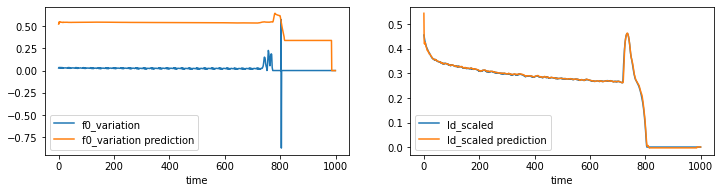

In [73]:
audio, audio_pred = get_preds(inputs , features)

In [74]:
print('Original Audio')
Audio(audio, rate=sr)

Original Audio


In [75]:
print('Predicted Audio')
Audio(audio_pred, rate=sr)

Predicted Audio


In [ ]:
output = list(chain.from_iterable(results))

[<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 9.9999976e-01,  4.3793666e-01],
       [ 9.9999964e-01,  4.2253003e-01],
       [ 9.9999934e-01,  4.2358643e-01],
       ...,
       [-2.9971853e-01,  9.7960979e-04],
       [-2.9971853e-01,  9.7960979e-04],
       [-2.9971853e-01,  9.7960979e-04]], dtype=float32)>, <tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 9.9999976e-01,  6.1197817e-01],
       [ 9.9999952e-01,  5.6366193e-01],
       [ 9.9999905e-01,  5.0411624e-01],
       ...,
       [-5.1883692e-01, -3.9260881e-04],
       [-5.2382296e-01, -3.4793513e-04],
       [-5.2461517e-01, -3.4079561e-04]], dtype=float32)>, <tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 9.9999976e-01,  7.7692693e-01],
       [ 9.9999976e-01,  7.6893598e-01],
       [ 9.9999976e-01,  7.5425321e-01],
       ...,
       [-2.9971853e-01,  9.7960979e-04],
       [-2.9971853e-01,  9.7960979e-04],
       [-2.9971853e-01,  9.7960979e-04]], dtype=float32)>, <tf.Tensor: shape=